In [1]:
import os
from PIL import Image
from sahi.model import MmdetDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction, predict
from sahi.utils.cv import visualize_object_predictions
import numpy as np
import pickle
from collections import defaultdict
import pandas as pd
import datetime

/homes/jrb21/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the model

In [4]:
! export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/vol/cuda/10.2.89-cudnn7.6.4.38/bin \
! export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/vol/cuda/10.2.89-cudnn7.6.4.38/lib \
! export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/vol/cuda/10.2.89-cudnn7.6.4.38/lib64:/vol/cuda/10.2.89-cudnn7.6.4.38/lib


/bin/bash: line 0: export: `!': not a valid identifier
/bin/bash: line 0: export: `!': not a valid identifier


In [5]:
! source /vol/cuda/10.2.89-cudnn7.6.4.38/setup.sh

In [10]:
detection_model = MmdetDetectionModel(
    model_path= "models-to-test/latest.pth",
    config_path= "mmdet_configs/xview_tood/tood_crop_300_500_cls_cars_trucks_1e-3_new_pipe.py",
    device='cuda' # or 'cpu'
)

ImportError: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.version.cuda

'10.2'

### Run inference on a single image

In [9]:
test_img_path = "WV3/A14_2_cambridge.tif"
width, height = (400,400)

sliced_pred_result = get_sliced_prediction(
    test_img_path,
    detection_model, 
    slice_width=width, 
    slice_height=height
)

Performing prediction on 500 number of slices.


In [10]:
sliced_pred_result.object_prediction_list

[ObjectPrediction<
     bbox: BoundingBox: <(615, 960, 634, 966), w: 19, h: 6>,
     mask: None,
     score: PredictionScore: <value: 0.510311484336853>,
     category: Category: <id: 0, name: Small Car>>,
 ObjectPrediction<
     bbox: BoundingBox: <(6015, 5130, 6030, 5142), w: 15, h: 12>,
     mask: None,
     score: PredictionScore: <value: 0.45968562364578247>,
     category: Category: <id: 0, name: Small Car>>,
 ObjectPrediction<
     bbox: BoundingBox: <(6084, 5128, 6101, 5142), w: 17, h: 14>,
     mask: None,
     score: PredictionScore: <value: 0.4479471743106842>,
     category: Category: <id: 0, name: Small Car>>,
 ObjectPrediction<
     bbox: BoundingBox: <(6080, 5158, 6085, 5172), w: 5, h: 14>,
     mask: None,
     score: PredictionScore: <value: 0.43382689356803894>,
     category: Category: <id: 0, name: Small Car>>,
 ObjectPrediction<
     bbox: BoundingBox: <(4074, 3557, 4090, 3571), w: 16, h: 14>,
     mask: None,
     score: PredictionScore: <value: 0.4292348623275757

### Batch prediction

In [ ]:
MODEL_PATH = "models-to-test/latest.pth"
MODEL_CONFIG_PATH = config_path= "mmdet_configs/xview_tood/tood_crop_300_500_cls_cars_trucks_1e-3_new_pipe.py"
EVAL_IMAGES_FOLDER_DIR = "WV3/crop_tiff"
EXPORT_VISUAL = True

INFERENCE_SETTING_TO_PARAMS = {
    "XVIEW_SAHI": {
        "no_standard_prediction": True,
        "no_sliced_prediction": False,
        "slice_size": 400,
        "overlap_ratio": 0,
    },
    "XVIEW_SAHI_PO": {
        "no_standard_prediction": True,
        "no_sliced_prediction": False,
        "slice_size": 400,
        "overlap_ratio": 0.20,
    },
    "XVIEW_SAHI_FI": {
        "no_standard_prediction": False,
        "no_sliced_prediction": False,
        "slice_size": 400,
        "overlap_ratio": 0,
    },
    "XVIEW_SAHI_FI_PO": {
        "no_standard_prediction": False,
        "no_sliced_prediction": False,
        "slice_size": 400,
        "overlap_ratio": 0.20,
    },
}

# Of the above 4 options I want to slice and not do full image size inference
INFERENCE_SETTING = "XVIEW_SAHI_PO"
setting_params = INFERENCE_SETTING_TO_PARAMS[INFERENCE_SETTING]

# From the evaluation py file I delete the eval dataset path and change the confidence to 0.3
result = predict(
    model_type="mmdet",
    model_path=MODEL_PATH,
    model_config_path=MODEL_CONFIG_PATH,
    model_confidence_threshold=0.2,
    model_device="cuda:0",
    model_category_mapping=None,
    model_category_remapping=None,
    source=EVAL_IMAGES_FOLDER_DIR,
    no_standard_prediction=setting_params["no_standard_prediction"],
    no_sliced_prediction=setting_params["no_sliced_prediction"],
    image_size=None,
    slice_height=setting_params["slice_size"],
    slice_width=setting_params["slice_size"],
    overlap_height_ratio=setting_params["overlap_ratio"],
    overlap_width_ratio=setting_params["overlap_ratio"],
    postprocess_type="GREEDYNMM",
    postprocess_match_metric="IOS",
    postprocess_match_threshold=0.5,
    postprocess_class_agnostic=True,
    novisual=not EXPORT_VISUAL,
    project="runs/highways",
    name=INFERENCE_SETTING,
    visual_bbox_thickness=1,
    visual_text_size=0.3,
    visual_text_thickness=1,
    visual_export_format="png",
    verbose=0,
    return_dict=True,
    force_postprocess_type=True,
    export_pickle = True,
)

### Process inference results

In [40]:
road_lengths = pd.read_csv('road_lengths.csv') 
road_lengths

,ddmmyy,time,area,focus,length,sites,filename
0,15/06/2021,11:09,birmingham,A452,2542.41,"9092, 9093",A452_birmingham
1,15/06/2021,11:09,birmingham,M6,5549.01,"18212, 19227",M6_birmingham
2,15/06/2021,11:09,birmingham,M42,7347.07,"10560, 10337, 10398",M42_birmingham
3,15/06/2021,11:09,birmingham,A45,4559.31,"9490, 9491",A45_birmingham
4,08/03/2022,11:12,thorpe,M25,8613.81,"1910, 6134",M25_thorpe
5,08/03/2022,11:12,thorpe,M25_2,6190.41,"5107, 4648",M25_2_thorpe
6,08/03/2022,11:12,thorpe,M3,9400.57,"14547, 14484, 14496, 14463, 14433",M3_thorpe
7,08/03/2022,11:12,thorpe,M3_2,4360.48,"14437, 14470",M3_2_thorpe
8,02/11/2021,11:26,cambridge,M11,5005.66,"2166, 3092, 4178, 9676",M11_cambridge
9,02/11/2021,11:26,cambridge,M11_2,3308.62,"3092, 4178",M11_2_cambridge


In [41]:
# Imort the true traffic flow numbers
clean_train_report_df = pd.read_feather('/vol/bitbucket/jrb21/project/Highways/traffic_reports/clean/full_clean_report_norm')
train_report_volumes = clean_train_report_df[['site_name','site_id','report_date','time_period_ending','time_interval','0-520cm','521-660cm','661-1160cm','1160+cm','avg_mph','total_volume','timestamp']]

sites = []
for x in list(road_lengths.sites):
    sites = sites + x.split(', ')
    
filtered_train_report = train_report_volumes[train_report_volumes.site_id.isin(sites)]

In [42]:
# For a particular row x in road_lengths get the correspoiding traffic data
def area_report(x):
    sites = x.sites.split(', ')
    day, month, year = x.ddmmyy.split('/')
    hour, minute  = x.time.split(':')
    
    # Get the nearest of the 15 minute intervals to compare to
    min_mod_15 = round((int(minute)+1)/15)
    nearest_minute_interval = 15*min_mod_15 - 1
    time = datetime.datetime(int(year),int(month),int(day), int(hour), int(nearest_minute_interval))
    x_report = filtered_train_report[(filtered_train_report.site_id.isin(sites)) & (filtered_train_report.timestamp == time)]
    return x_report

# Add the reports to the dataframe
road_lengths['report'] = road_lengths.apply(area_report, axis=1)
# Extract values from the report
road_lengths['0-520cm'] = road_lengths.apply(lambda x: x.report['0-520cm'].sum(), axis=1)
road_lengths['521-660cm'] = road_lengths.apply(lambda x: x.report['521-660cm'].sum(), axis=1)
road_lengths['661-1160cm'] = road_lengths.apply(lambda x: x.report['661-1160cm'].sum(), axis=1)
road_lengths['1160+cm'] = road_lengths.apply(lambda x: x.report['1160+cm'].sum(), axis=1)
road_lengths['total_volume'] = road_lengths.apply(lambda x: x.report['total_volume'].sum(), axis=1)
road_lengths['avg_mph'] = road_lengths.apply(lambda x: x.report.avg_mph.astype(int).mean(), axis=1)

In [43]:
road_lengths

,ddmmyy,time,area,focus,length,sites,filename,report,0-520cm,521-660cm,661-1160cm,1160+cm,total_volume,avg_mph
0,15/06/2021,11:09,birmingham,A452,2542.41,"9092, 9093",A452_birmingham,site_name site_id report_date...,321,44,46,22,433,53.500000
1,15/06/2021,11:09,birmingham,M6,5549.01,"18212, 19227",M6_birmingham,site_name site_id report_date...,366,66,44,113,589,56.000000
2,15/06/2021,11:09,birmingham,M42,7347.07,"10560, 10337, 10398",M42_birmingham,site_name site_id report_dat...,916,321,247,337,1821,60.000000
3,15/06/2021,11:09,birmingham,A45,4559.31,"9490, 9491",A45_birmingham,site_name site_id report_date...,395,28,66,35,524,54.000000
4,08/03/2022,11:12,thorpe,M25,8613.81,"1910, 6134",M25_thorpe,site_name site_id report_da...,1853,250,241,209,2553,63.000000
5,08/03/2022,11:12,thorpe,M25_2,6190.41,"5107, 4648",M25_2_thorpe,site_name site_id report_da...,1845,229,209,223,2506,61.000000
6,08/03/2022,11:12,thorpe,M3,9400.57,"14547, 14484, 14496, 14463, 14433",M3_thorpe,site_name site_id report_da...,438,136,80,39,693,56.000000
7,08/03/2022,11:12,thorpe,M3_2,4360.48,"14437, 14470",M3_2_thorpe,site_name site_id report_dat...,1091,222,132,159,1604,57.500000
8,02/11/2021,11:26,cambridge,M11,5005.66,"2166, 3092, 4178, 9676",M11_cambridge,site_name site_id report_da...,731,61,59,130,981,53.250000
9,02/11/2021,11:26,cambridge,M11_2,3308.62,"3092, 4178",M11_2_cambridge,site_name site_id report_da...,574,56,50,127,807,63.500000


In [45]:
# Initially set the column names so they agree with the names in the pickle files
detections = pd.DataFrame(
   {
       "filename": [],
       "small_car_detections": [],
       "bus_detections": [],
       "pickup_truck_detections": [],
       "utility_truck_detections": [],
       "truck_detections": [],
       "cargo_truck_detections": [],
       "truck_w_box_detections": [],
       "truck_tractor_detections": [],
       "trailer_detections": [],
       "truck_w_flatbed_detections": [],
       "truck_w_liquid_detections": [],
       "all_vehicle_detections": [],
       "length_m": [],
       
   }
)

# Import the predictions the pickle files
pickle_folder = 'runs/highways/XVIEW_SAHI_PO17/pickles'
prediction_lists = defaultdict()

for i, file in enumerate(os.listdir(pickle_folder)):
    with (open(os.path.join(pickle_folder, file), "rb")) as f:
        prediction_list = pickle.load(f)
    filename = file.split('.')[0]
    prediction_lists[filename] = prediction_list
    counts = defaultdict(int)
    for pred in prediction_list:
        counts[pred.category.name] +=1
        
    detections.loc[i] = [filename, 
                 counts["Small Car"],
                 counts["Bus"],
                 counts["Pickup Truck"],
                 counts["Utility Truck"],
                 counts["Truck"],
                 counts["Cargo Truck"],
                 counts["Truck w/Box"],
                 counts["Truck Tractor"],
                 counts["Trailer"],
                 counts["Truck w/Flatbed"],
                 counts["Truck w/Liquid"],
                 sum([x for x in counts.values()]),
                 road_lengths[road_lengths.filename == filename].length.values[0]]

In [46]:
detections

,filename,small_car_detections,bus_detections,pickup_truck_detections,utility_truck_detections,truck_detections,cargo_truck_detections,truck_w_box_detections,truck_tractor_detections,trailer_detections,truck_w_flatbed_detections,truck_w_liquid_detections,all_vehicle_detections,length_m
0,M6_birmingham,61,3,0,0,14,2,12,0,2,0,0,94,5549.01
1,M4_bristol,455,15,0,0,10,1,9,0,1,0,0,491,8535.34
2,A45_birmingham,42,2,0,0,11,2,2,0,1,0,0,60,4559.31
3,M25_2_thorpe,199,6,0,0,21,1,7,0,1,0,0,235,6190.41
4,M3_2_thorpe,122,0,0,0,4,0,0,0,0,0,0,126,4360.48
5,M25_thorpe,274,31,0,0,45,2,15,0,0,0,0,367,8613.81
6,M11_2_epping,118,4,0,0,25,3,16,0,3,1,0,170,7575.47
7,M42_birmingham,151,18,0,0,15,6,21,0,0,0,0,211,7347.07
8,M3_thorpe,88,0,0,0,19,0,1,0,2,0,0,110,9400.57
9,M11_cambridge,47,10,0,0,9,1,7,0,0,0,0,74,5005.66


In [47]:
def detection_report(x):
    detections_report = detections[detections.filename == x.filename]
    return detections_report

In [48]:
road_lengths['det_report'] = road_lengths.apply(detection_report, axis=1)

In [49]:
road_lengths.det_report.iloc[0].small_car_detections

18    25
Name: small_car_detections, dtype: int64

In [50]:
road_lengths['small_car_detections'] = road_lengths.apply(lambda x: x.det_report.small_car_detections.sum(), axis=1)
road_lengths['bus_detections'] = road_lengths.apply(lambda x: x.det_report.bus_detections.sum(), axis=1)
road_lengths['pickup_truck_detections'] = road_lengths.apply(lambda x: x.det_report.pickup_truck_detections.sum(), axis=1)
road_lengths['utility_truck_detections'] = road_lengths.apply(lambda x: x.det_report.utility_truck_detections.sum(), axis=1)
road_lengths['truck_detections'] = road_lengths.apply(lambda x: x.det_report.truck_detections.sum(), axis=1)
road_lengths['cargo_truck_detections'] = road_lengths.apply(lambda x: x.det_report.cargo_truck_detections.sum(), axis=1)
road_lengths['truck_w_box_detections'] = road_lengths.apply(lambda x: x.det_report.truck_w_box_detections.sum(), axis=1)
road_lengths['truck_tractor_detections'] = road_lengths.apply(lambda x: x.det_report.truck_tractor_detections.sum(), axis=1)
road_lengths['trailer_detections'] = road_lengths.apply(lambda x: x.det_report.trailer_detections.sum(), axis=1)
road_lengths['truck_w_flatbed_detections'] = road_lengths.apply(lambda x: x.det_report.truck_w_flatbed_detections.sum(), axis=1)
road_lengths['truck_w_liquid_detections'] = road_lengths.apply(lambda x: x.det_report.truck_w_liquid_detections.sum(), axis=1)
road_lengths['all_vehicle_detections'] = road_lengths.apply(lambda x: x.det_report.all_vehicle_detections.sum(), axis=1)


In [51]:
road_lengths[['filename', '0-520cm', '521-660cm', '661-1160cm', '1160+cm',
       'total_volume', 'avg_mph', 'small_car_detections',
       'bus_detections', 'pickup_truck_detections', 'utility_truck_detections',
       'truck_detections', 'cargo_truck_detections', 'truck_w_box_detections',
       'truck_tractor_detections', 'trailer_detections',
       'truck_w_flatbed_detections', 'truck_w_liquid_detections',
       'all_vehicle_detections']]

,filename,0-520cm,521-660cm,661-1160cm,1160+cm,total_volume,avg_mph,small_car_detections,bus_detections,pickup_truck_detections,utility_truck_detections,truck_detections,cargo_truck_detections,truck_w_box_detections,truck_tractor_detections,trailer_detections,truck_w_flatbed_detections,truck_w_liquid_detections,all_vehicle_detections
0,A452_birmingham,321,44,46,22,433,53.500000,25,1,0,0,2,0,1,0,0,0,0,29
1,M6_birmingham,366,66,44,113,589,56.000000,61,3,0,0,14,2,12,0,2,0,0,94
2,M42_birmingham,916,321,247,337,1821,60.000000,151,18,0,0,15,6,21,0,0,0,0,211
3,A45_birmingham,395,28,66,35,524,54.000000,42,2,0,0,11,2,2,0,1,0,0,60
4,M25_thorpe,1853,250,241,209,2553,63.000000,274,31,0,0,45,2,15,0,0,0,0,367
5,M25_2_thorpe,1845,229,209,223,2506,61.000000,199,6,0,0,21,1,7,0,1,0,0,235
6,M3_thorpe,438,136,80,39,693,56.000000,88,0,0,0,19,0,1,0,2,0,0,110
7,M3_2_thorpe,1091,222,132,159,1604,57.500000,122,0,0,0,4,0,0,0,0,0,0,126
8,M11_cambridge,731,61,59,130,981,53.250000,47,10,0,0,9,1,7,0,0,0,0,74
9,M11_2_cambridge,574,56,50,127,807,63.500000,20,2,0,0,6,0,2,0,1,0,0,31


### Convert Detections into 15 minute counts

In [52]:
road_lengths['length_milles'] = road_lengths.length.apply(lambda x: x/1000 *5/8)

In [53]:
road_lengths['time_to_cross_hour'] = road_lengths.apply(lambda x : x.length_milles/x.avg_mph * 1/2 , axis=1)
road_lengths['time_to_cross_min'] = road_lengths.apply(lambda x : x.time_to_cross_hour * 60 , axis=1)

In [54]:
 detection_cols = ['small_car_detections',
 'bus_detections',
 'pickup_truck_detections',
 'utility_truck_detections',
 'truck_detections',
 'cargo_truck_detections',
 'truck_w_box_detections',
 'truck_tractor_detections',
 'trailer_detections',
 'truck_w_flatbed_detections',
 'truck_w_liquid_detections',
 'all_vehicle_detections']

In [55]:
for col in detection_cols:
    pred_col = col.replace('detections', 'pred')
    road_lengths[pred_col] = road_lengths[col] * 15 / road_lengths['time_to_cross_min']

In [56]:
pd.set_option('display.max_columns', None)

In [57]:
road_lengths

,ddmmyy,time,area,focus,length,sites,filename,report,0-520cm,521-660cm,661-1160cm,1160+cm,total_volume,avg_mph,det_report,small_car_detections,bus_detections,pickup_truck_detections,utility_truck_detections,truck_detections,cargo_truck_detections,truck_w_box_detections,truck_tractor_detections,trailer_detections,truck_w_flatbed_detections,truck_w_liquid_detections,all_vehicle_detections,length_milles,time_to_cross_hour,time_to_cross_min,small_car_pred,bus_pred,pickup_truck_pred,utility_truck_pred,truck_pred,cargo_truck_pred,truck_w_box_pred,truck_tractor_pred,trailer_pred,truck_w_flatbed_pred,truck_w_liquid_pred,all_vehicle_pred
0,15/06/2021,11:09,birmingham,A452,2542.41,"9092, 9093",A452_birmingham,site_name site_id report_date...,321,44,46,22,433,53.500000,filename small_car_detections bus...,25,1,0,0,2,0,1,0,0,0,0,29,1.589006,0.014851,0.891032,420.860522,16.834421,0.0,0.0,33.668842,0.000000,16.834421,0.0,0.000000,0.000000,0.0,488.198206
1,15/06/2021,11:09,birmingham,M6,5549.01,"18212, 19227",M6_birmingham,site_name site_id report_date...,366,66,44,113,589,56.000000,filename small_car_detections bus_de...,61,3,0,0,14,2,12,0,2,0,0,94,3.468131,0.030965,1.857927,492.484245,24.220537,0.0,0.0,113.029171,16.147024,96.882147,0.0,16.147024,0.000000,0.0,758.910148
2,15/06/2021,11:09,birmingham,M42,7347.07,"10560, 10337, 10398",M42_birmingham,site_name site_id report_dat...,916,321,247,337,1821,60.000000,filename small_car_detections bus_d...,151,18,0,0,15,6,21,0,0,0,0,211,4.591919,0.038266,2.295959,986.515713,117.597900,0.0,0.0,97.998250,39.199300,137.197549,0.0,0.000000,0.000000,0.0,1378.508712
3,15/06/2021,11:09,birmingham,A45,4559.31,"9490, 9491",A45_birmingham,site_name site_id report_date...,395,28,66,35,524,54.000000,filename small_car_detections bus_d...,42,2,0,0,11,2,2,0,1,0,0,60,2.849569,0.026385,1.583094,397.954954,18.950236,0.0,0.0,104.226297,18.950236,18.950236,0.0,9.475118,0.000000,0.0,568.507077
4,08/03/2022,11:12,thorpe,M25,8613.81,"1910, 6134",M25_thorpe,site_name site_id report_da...,1853,250,241,209,2553,63.000000,filename small_car_detections bus_detec...,274,31,0,0,45,2,15,0,0,0,0,367,5.383631,0.042727,2.563634,1603.193012,181.383151,0.0,0.0,263.298122,11.702139,87.766041,0.0,0.000000,0.000000,0.0,2147.342465
5,08/03/2022,11:12,thorpe,M25_2,6190.41,"5107, 4648",M25_2_thorpe,site_name site_id report_da...,1845,229,209,223,2506,61.000000,filename small_car_detections bus_det...,199,6,0,0,21,1,7,0,1,0,0,235,3.869006,0.031713,1.902790,1568.749081,47.298967,0.0,0.0,165.546385,7.883161,55.182128,0.0,7.883161,0.000000,0.0,1852.542885
6,08/03/2022,11:12,thorpe,M3,9400.57,"14547, 14484, 14496, 14463, 14433",M3_thorpe,site_name site_id report_da...,438,136,80,39,693,56.000000,filename small_car_detections bus_detect...,88,0,0,0,19,0,1,0,2,0,0,110,5.875356,0.052459,3.147512,419.378825,0.000000,0.0,0.0,90.547701,0.000000,4.765668,0.0,9.531337,0.000000,0.0,524.223531
7,08/03/2022,11:12,thorpe,M3_2,4360.48,"14437, 14470",M3_2_thorpe,site_name site_id report_dat...,1091,222,132,159,1604,57.500000,filename small_car_detections bus_dete...,122,0,0,0,4,0,0,0,0,0,0,126,2.725300,0.023698,1.421896,1287.014274,0.000000,0.0,0.0,42.197189,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1329.211463
8,02/11/2021,11:26,cambridge,M11,5005.66,"2166, 3092, 4178, 9676",M11_cambridge,site_name site_id report_da...,731,61,59,130,981,53.250000,filename small_car_detections bus_de...,47,10,0,0,9,1,7,0,0,0,0,74,3.128537,0.029376,1.762556,399.987214,85.103663,0.0,0.0,76.593296,8.510366,59.572564,0.0,0.000000,0.000000,0.0,629.767104
9,02/11/2021,11:26,cambridge,M11_2,3308.62,"3092, 4178",M11_2_cambridge,site_name site_id report_da...,574,56,50,127,807,63.500000,filename small_car_detections bus...,20,2,0,0,6,0,2,0,1,0,0,31,2.067887,0.016283,0.976955,307.076666,30.707667,0.0,0.0,92.123000,0.000000,30.707667,0.0,15.353833,0.000000,0.0,475.968833


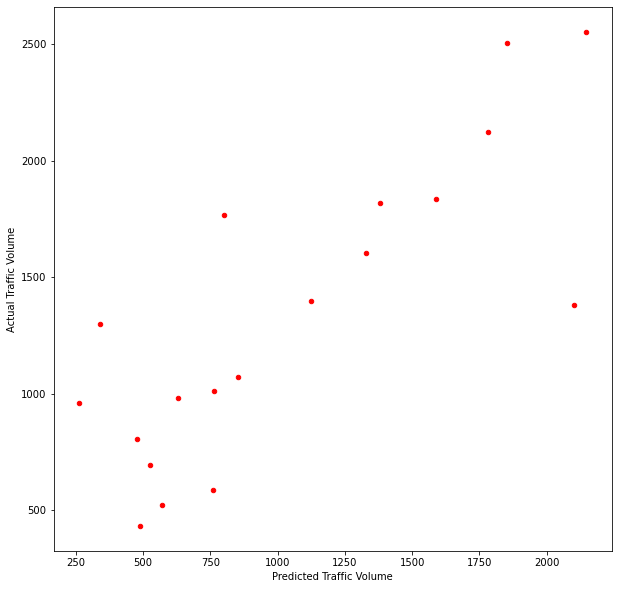

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
road_lengths.plot('all_vehicle_pred','total_volume', c='red', kind='scatter', ax=ax)
ax.set_xlabel('Predicted Traffic Volume')
ax.set_ylabel('Actual Traffic Volume')
plt.show()

In [20]:
X = np.array(road_lengths['all_vehicle_pred']).reshape(-1,1)
y = np.array(road_lengths['total_volume']).reshape(-1,1)
theta = np.linalg.inv(X.T @ X) @ y.T @ X
theta = theta[0][0]

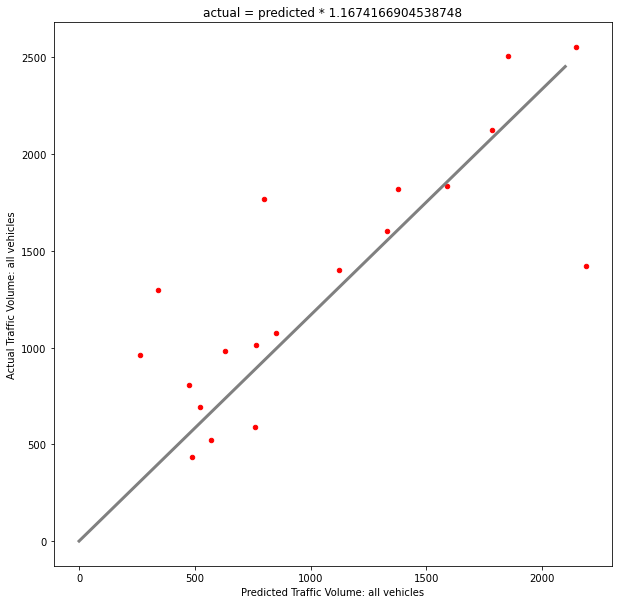

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot([0,2100],[0,2100*theta], lw=3, c='grey')
road_lengths.plot('all_vehicle_pred','total_volume', c='red', kind='scatter', ax=ax)
ax.set_xlabel('Predicted Traffic Volume: all vehicles')
ax.set_ylabel('Actual Traffic Volume: all vehicles')
ax.set_title(label=f"actual = predicted * {theta}")
plt.show()

In [23]:
import seaborn as sns

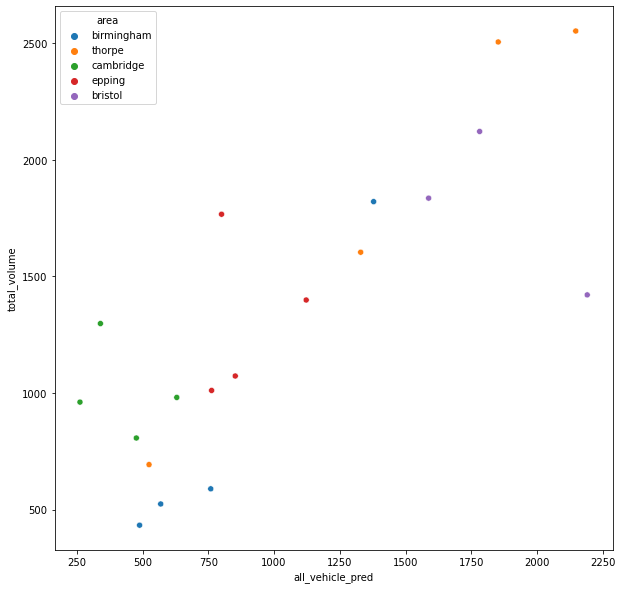

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='all_vehicle_pred', y='total_volume', hue='area', data=road_lengths, ax=ax)
plt.show()

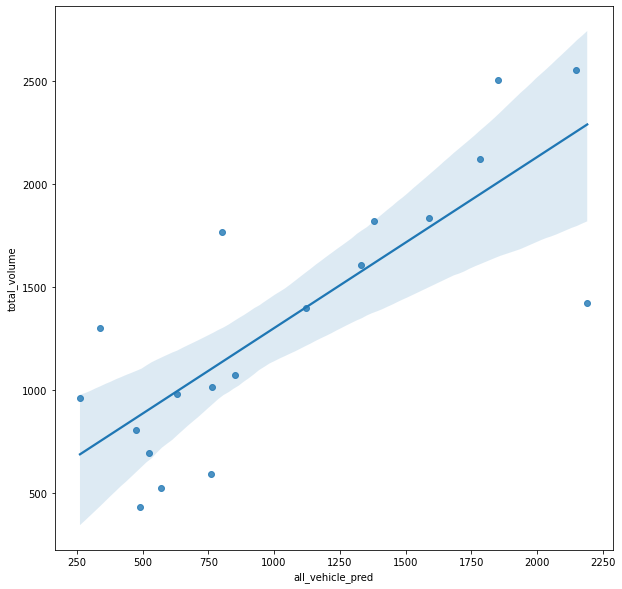

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(x='all_vehicle_pred', y='total_volume', data=road_lengths, ax=ax)
plt.show()

### Export Results

In [31]:
traffic_predictions = road_lengths[['ddmmyy', 'time', 'area', 'focus', 'length', 'sites', 'filename',
       '0-520cm', '521-660cm', '661-1160cm', '1160+cm',
       'total_volume', 'avg_mph', 'small_car_detections',
       'bus_detections', 'pickup_truck_detections', 'utility_truck_detections',
       'truck_detections', 'cargo_truck_detections', 'truck_w_box_detections',
       'truck_tractor_detections', 'trailer_detections',
       'truck_w_flatbed_detections', 'truck_w_liquid_detections',
       'all_vehicle_detections', 'length_milles', 'time_to_cross_hour',
       'time_to_cross_min', 'small_car_pred', 'bus_pred', 'pickup_truck_pred',
       'utility_truck_pred', 'truck_pred', 'cargo_truck_pred',
       'truck_w_box_pred', 'truck_tractor_pred', 'trailer_pred',
       'truck_w_flatbed_pred', 'truck_w_liquid_pred', 'all_vehicle_pred']]

In [32]:
traffic_predictions.to_feather('traffic_predictions')

### AADT

In [115]:
clean_train_report_df[clean_train_report_df.site_id == '9093']

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,hour,DOW,month,location,float_time,0-520cm_normalised,521-660cm_normalised,661-1160cm_normalised,1160+cm_normalised,total_volume_normalised
1517755,7642/2,9093,2019-03-19T00:00:00,00:14:00,0,21,3,1,5,53,30,2019-03-19 00:14:00,0,1,3,birmingham,1.552954e+09,0.169027,0.328974,0.111253,0.634763,0.199700
1517756,7642/2,9093,2019-03-19T00:00:00,00:29:00,1,11,0,1,7,53,19,2019-03-19 00:29:00,0,1,3,birmingham,1.552955e+09,0.088538,0.000000,0.111253,0.888668,0.126476
1517757,7642/2,9093,2019-03-19T00:00:00,00:44:00,2,15,3,2,5,54,25,2019-03-19 00:44:00,0,1,3,birmingham,1.552956e+09,0.120733,0.328974,0.222506,0.634763,0.166416
1517758,7642/2,9093,2019-03-19T00:00:00,00:59:00,3,5,1,1,8,53,15,2019-03-19 00:59:00,0,1,3,birmingham,1.552957e+09,0.040244,0.109658,0.111253,1.015621,0.099850
1517759,7642/2,9093,2019-03-19T00:00:00,01:14:00,4,13,0,6,2,59,21,2019-03-19 01:14:00,1,1,3,birmingham,1.552958e+09,0.104636,0.000000,0.667518,0.253905,0.139790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619463,7642/2,9093,2022-04-08T00:00:00,22:59:00,91,54,4,3,11,53,72,2022-04-08 22:59:00,22,4,4,birmingham,1.649459e+09,0.434640,0.438632,0.333759,1.396478,0.479279
1619464,7642/2,9093,2022-04-08T00:00:00,23:14:00,92,41,2,1,7,52,51,2022-04-08 23:14:00,23,4,4,birmingham,1.649460e+09,0.330004,0.219316,0.111253,0.888668,0.339489
1619465,7642/2,9093,2022-04-08T00:00:00,23:29:00,93,47,0,3,5,53,55,2022-04-08 23:29:00,23,4,4,birmingham,1.649461e+09,0.378298,0.000000,0.333759,0.634763,0.366116
1619466,7642/2,9093,2022-04-08T00:00:00,23:44:00,94,50,5,4,6,52,65,2022-04-08 23:44:00,23,4,4,birmingham,1.649461e+09,0.402444,0.548290,0.445012,0.761715,0.432683
